# Package

In [1]:
import os
import time

import numpy as np
import pandas as pd
from sklearn.utils import shuffle, resample
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print("Package is ready.")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Package is ready.


# Hyperparameters

## Plotting parameters

In [2]:
matplotlib.rcParams['figure.figsize'] = ((8/2.54)*2, (6/2.54)*2)
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 1

## Training parameters

In [3]:
#Constants
N_TASKS = 6
N_FOLD = 5
EX_TEST = 0
EXPLANATION_ = "BN_FC_Ion_closed"
EPSILON = 0.0001
TRAINING_EPOCHS = 50000
BATCH_SIZE = 16
DISPLAY_STEP = 500

N_HIDDEN = 512

SHIELD = 999
LIMIT = 3002

# Data handling

## Date loading

In [4]:
ion_label = pd.read_excel("../data/SW_Ion/Ion concentration_meq_20171109-20180426.xlsx", skiprows=1, index_col="date")

In [5]:
ion_label = ion_label[~(ion_label.index < '2018-01-12')]
#ion_label.drop(["N"], axis=1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if "Unnamed:" in columns], axis= 1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if ".1" in columns], axis= 1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if ".2" in columns], axis= 1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if ".3" in columns], axis= 1, inplace=True)
ion_label.dropna(inplace=True)
#ion_label.drop([pd.Timestamp("2018-04-23"), pd.Timestamp("2018-04-12"), pd.Timestamp("2018-04-05")], axis=0, inplace=True)
ion_label.drop([pd.Timestamp("2018-04-13")], axis=0, inplace=True)

In [6]:
ion_label.index += pd.Timedelta("16h")

In [7]:
ion_label = ion_label.sample(frac=1.0)

In [8]:
raw_closed = pd.read_csv("./results/closed_data.csv", index_col="TIMESTAMP")
raw_closed.index = pd.DatetimeIndex(raw_closed.index)
raw_closed = raw_closed[np.abs(raw_closed-raw_closed.mean())<=(3*raw_closed.std())]
raw_closed["RootTemp(1)"][0] = 20
raw_closed.drop(["ECS(3)", "InjDrgVR(3)", "DrgDaily(3)", "DrgV(3)"], axis=1, inplace=True)

In [9]:
raw_closed.interpolate("linear", inplace=True)

# raw_closed.index = (raw_closed.index).round(INTERVAL)
# raw_closed = raw_closed.groupby(raw_closed.index).mean()

In [10]:
MAXS = raw_closed.max()
MINS = raw_closed.min()
LABELMAXS = ion_label.max()
LABELMINS = ion_label.min()

In [11]:
raw_closed = (raw_closed - MINS) / (MAXS - MINS)
ion_label = (ion_label - LABELMINS) / (LABELMAXS - LABELMINS)

In [12]:
env_input = raw_closed.reindex(ion_label.index)

In [13]:
train_inputs = []
train_labels = []
test_inputs = []
test_labels = []

kf = KFold(n_splits=N_FOLD, shuffle=True)
for train_index, test_index in kf.split(ion_label):
    train_inputs.append(env_input.iloc[train_index, :])
    train_labels.append(ion_label.iloc[train_index, :])
    test_inputs.append(env_input.iloc[test_index, :])
    test_labels.append(ion_label.iloc[test_index, :])

In [14]:
n_output = 6
n_features = test_inputs[0].shape[1]
n_train = train_inputs[0].shape[0]
n_test = test_inputs[0].shape[0]

print("number of output: %d" % n_output)
print("number of feature: %d" % n_features)
print("number of train data: %d" % n_train)
print("number of test data: %d" % n_test)

number of output: 6
number of feature: 23
number of train data: 40
number of test data: 11


## Network preparation

### Constructing networks

In [15]:
def FC(x, size, scope):
    return tf.contrib.layers.fully_connected(x, size, activation_fn=None, scope=scope)

def BN_FC(x, n_hidden, phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(x, n_hidden, activation_fn=None, scope='FC')
        h2 = tf.layers.batch_normalization(h1, training=phase)
        return tf.nn.relu(h2, 'relu')
    
def layers(_x, _n_hidden, _phase):

    h1 = BN_FC(_x, _n_hidden, _phase, "layer1")
    h2 = BN_FC(h1, _n_hidden, _phase, "layer2")
    h3 = BN_FC(h2, _n_hidden, _phase, "layer3")
    h4 = BN_FC(h3, _n_hidden, _phase, "layer4")
#     h5 = BN_FC(h4, _n_hidden, _phase, "layer5")
#     h6 = BN_FC(h5, _n_hidden, _phase, "layer6")
#     h7 = BN_FC(h6, _n_hidden, _phase, "layer7")
#     h8 = BN_FC(h7, _n_hidden, _phase, "layer8")
#     h9 = BN_FC(h8, _n_hidden, _phase, "layer9")
#     h10 = BN_FC(h9, _n_hidden, _phase, "layer10")
#     h11 = BN_FC(h10, _n_hidden, _phase, "layer11")
#     h12 = BN_FC(h11, _n_hidden, _phase, "layer12")
#     h13 = BN_FC(h12, _n_hidden, _phase, "layer13")
#     h14 = BN_FC(h13, _n_hidden, _phase, "layer14")
#     h15 = BN_FC(h14, _n_hidden, _phase, "layer15")
#     h16 = BN_FC(h15, _n_hidden, _phase, "layer16")
    out = FC(h4, n_output, "out")

    return out

In [16]:
results_list = []
label_list = []
for FOLD in range(N_FOLD):
    global_step = tf.Variable(0, trainable=False)    
    LEARNING_RATE =  tf.train.exponential_decay(0.005, global_step, 1500, 0.96, staircase=True)
    EXPLANATION = EXPLANATION_+ "_F" + str(FOLD+1)
    train_input, train_label = train_inputs[FOLD], train_labels[FOLD]
    test_input, test_label = test_inputs[FOLD], test_labels[FOLD]
    
    # tf Graph input
    x = tf.placeholder("float", [None, n_features], name = "F"+str(FOLD+1)+"input")
    y = tf.placeholder("float", [None, n_output], name = "F"+str(FOLD+1)+"output_1")
    phase = tf.placeholder(tf.bool, name='phase')

    # Construct model
    pred = layers(x, N_HIDDEN, phase)

    # Define loss and optimizer
    cost = tf.losses.mean_squared_error(labels=y, predictions=pred)


    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    optimizer_ = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    with tf.control_dependencies(update_ops):
        #optimizer = optimizer_.minimize(joint_cost, global_step=global_step)
        op = optimizer_.minimize(cost, global_step=global_step)

    # Accuracy
    total_error = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y, pred)))
    R_squared = tf.subtract(1., tf.divide(unexplained_error, total_error))

    accuracy = R_squared
    # Initializing the variables
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

    # Do some optimizations
    sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
    sess.run(init)

    # Launch the graph
    ex_acc = 0
    best_acc = 0
    early_stop_buffer = 0
    # Keep training until reach max iterations
    start = time.time()

    for EPOCH in range(TRAINING_EPOCHS):
        
        batch_x, batch_y = resample(train_input, train_label, n_samples = BATCH_SIZE, replace = False)
        loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y, phase: 1})
        
        sess.run(op, feed_dict={x: batch_x, y: batch_y, phase: 1})
        
        test_acc = sess.run(accuracy, feed_dict={x: test_input, y: test_label, phase: 0})
        
        
        if test_acc > ex_acc:
            if EPOCH <= SHIELD:
                pass
            elif test_acc > best_acc:
                bestpath = "./models/best_trained_" + EXPLANATION + ".ckpt"
                save_path = saver.save(sess, bestpath)
                best_acc = test_acc
                early_stop_buffer = 0
        else:
            early_stop_buffer += 1

        if early_stop_buffer >= LIMIT:
            print ("\nEarly stopping.")
            break     

        ex_acc = test_acc
        if EPOCH % DISPLAY_STEP == 0:
            print ("Epoch: %8d/%8d cost: %.6f, best: %.6f" % (EPOCH, TRAINING_EPOCHS, loss, best_acc))
            train_acc = sess.run(accuracy, feed_dict={x: train_input, y: train_label, phase: 0})
            test_acc = sess.run(accuracy, feed_dict={x: test_input, y: test_label, phase: 0})
            print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc, test_acc))


    print ("Epoch: %8d/%8d cost: %.6f, best: %.6f" % (EPOCH+1, TRAINING_EPOCHS, loss, best_acc))
    train_acc = sess.run(accuracy, feed_dict={x: train_input, y: train_label, phase: 0})
    test_acc = sess.run(accuracy, feed_dict={x: test_input, y: test_label, phase: 0})
    print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc,test_acc))

    end = time.time() - start
    print ("Optimization Finished\ntraining time: %.2f sec." % (end))
    
    #Choose best model
    bestpath = "./models/best_trained_" + EXPLANATION + ".ckpt"
    saver.restore(sess, bestpath)

    print ("Training Accuracy:", sess.run(accuracy, feed_dict={x: train_input, y: train_label, phase: 0}))
    print ("Test Accuracy:", sess.run(accuracy, feed_dict={x: test_input, y: test_label, phase: 0}))

    estimation_result = sess.run(pred,feed_dict={x: test_input, phase: 0})
    estimation_result = pd.DataFrame(estimation_result, index=test_label.index, columns=test_label.columns)
    results_list.append(estimation_result)
    label_list.append(test_label)

    tf.reset_default_graph()
    sess.close()
    
print("All fold vaildation were ended.")

Epoch:        0/   50000 cost: 0.869191, best: 0.000000
Training Acc: -1.514, Test Acc: -2.066
Epoch:      500/   50000 cost: 0.012412, best: 0.000000
Training Acc: 0.665, Test Acc: 0.130
Epoch:     1000/   50000 cost: 0.002669, best: 0.000000
Training Acc: 0.671, Test Acc: 0.349
Epoch:     1500/   50000 cost: 0.003159, best: 0.682843
Training Acc: 0.863, Test Acc: 0.470
Epoch:     2000/   50000 cost: 0.002627, best: 0.693717
Training Acc: 0.858, Test Acc: 0.597
Epoch:     2500/   50000 cost: 0.003144, best: 0.720813
Training Acc: 0.871, Test Acc: 0.639
Epoch:     3000/   50000 cost: 0.004092, best: 0.726988
Training Acc: 0.843, Test Acc: 0.639
Epoch:     3500/   50000 cost: 0.002033, best: 0.756711
Training Acc: 0.800, Test Acc: 0.692
Epoch:     4000/   50000 cost: 0.000744, best: 0.756711
Training Acc: 0.846, Test Acc: 0.702
Epoch:     4500/   50000 cost: 0.001341, best: 0.764499
Training Acc: 0.829, Test Acc: 0.621
Epoch:     5000/   50000 cost: 0.001006, best: 0.764499
Training Acc

Epoch:     4500/   50000 cost: 0.001152, best: 0.665076
Training Acc: 0.808, Test Acc: 0.605
Epoch:     5000/   50000 cost: 0.000540, best: 0.665817
Training Acc: 0.870, Test Acc: 0.631
Epoch:     5500/   50000 cost: 0.000600, best: 0.724874
Training Acc: 0.846, Test Acc: 0.655
Epoch:     6000/   50000 cost: 0.000394, best: 0.724874
Training Acc: 0.823, Test Acc: 0.634
Epoch:     6500/   50000 cost: 0.000466, best: 0.724874
Training Acc: 0.840, Test Acc: 0.639
Epoch:     7000/   50000 cost: 0.000543, best: 0.724874
Training Acc: 0.848, Test Acc: 0.584
Epoch:     7500/   50000 cost: 0.000270, best: 0.724874
Training Acc: 0.838, Test Acc: 0.581
Epoch:     8000/   50000 cost: 0.000159, best: 0.724874
Training Acc: 0.779, Test Acc: 0.643
Epoch:     8500/   50000 cost: 0.000493, best: 0.724874
Training Acc: 0.819, Test Acc: 0.544
Epoch:     9000/   50000 cost: 0.000316, best: 0.724874
Training Acc: 0.816, Test Acc: 0.550
Epoch:     9500/   50000 cost: 0.000105, best: 0.724874
Training Acc: 

## Result analysis

### Restoring from preprocess

In [17]:
final_result = pd.concat(results_list).sort_index()

In [18]:
final_result = ((LABELMAXS - LABELMINS) * final_result) + LABELMINS
restored_label = ((LABELMAXS - LABELMINS) * ion_label) + LABELMINS

### One to one graph

R2 score:-0.722
MSE:6.477
R2 score:-0.432
MSE:33.604
R2 score:-0.482
MSE:4.831
R2 score:-0.428
MSE:10.203
R2 score:-0.431
MSE:36.874
R2 score:-0.730
MSE:0.307


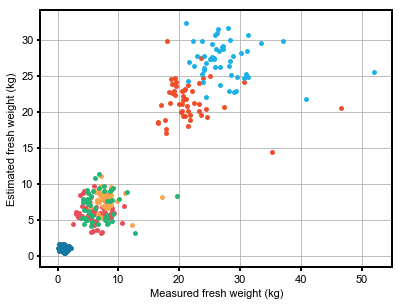

In [19]:
# x_linear = np.arange(-1,2)
# y_linear = x_linear

# one_to_one_line = plt.plot(x_linear, y_linear,'k--', zorder=1)
for _ in range(6):
    estimation_scatter1 = plt.scatter(restored_label.iloc[:, _], final_result.iloc[:, _],
                                 s=MARKER_SIZE, c=cmap[_], label = restored_label.columns[_], zorder=2)

    print("R2 score:%.3f" % r2_score(restored_label.iloc[:, _], final_result.iloc[:, _]))
    print("MSE:%.3f" % mean_squared_error(restored_label.iloc[:, _], final_result.iloc[:, _]))
#plt.axis([-0.1, 0.7, -0.1, 0.7])
plt.xlabel("Measured fresh weight (kg)")
plt.ylabel("Estimated fresh weight (kg)")
plt.grid(True)
plt.show()


In [20]:
r2_score(restored_label, final_result)

-0.5376785830044125

In [21]:
np.sqrt(mean_squared_error(restored_label, final_result))

3.9220557774573903